# **About the project**
* Speech Emotion Recognition project . This project is emphasizing on recongnising the human emotion and states from the speech.

#**Data description**
* The data used here is the RAVDESS dataset; **this is the Ryerson Audio-Visual Database** of Emotional Speech and Song dataset, and is free to download.
* **Filename identifiers**

  Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

  Vocal channel (01 = speech, 02 = song).

  ***Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).***

  Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

  Statement Used in the file for emotion depiction  (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

  Repetition (01 = 1st repetition, 02 = 2nd repetition).

  Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

* **Filename example: 03-02-06-01-02-01-12.wav**

 Audio-only (03)  
 Song (02)  
 Fearful (06)  
 Normal intensity (01)  
 Statement "dogs" (02)  
 1st Repetition (01)  
 12th Actor (12)  
 Female, as the actor ID number is even.

# **Model description**
## We have used two model for this project.
###  **Model 1**
 * MLPClassifier-- Multi layer perceptron classifier model  is a feedforward ANN model that maps input data sets to a set of appropriate outputs.

### **Model 2**
   * CNN -- Convolutional Neutral Network Model.CNN is designed to automatically and adaptively learn spatial hierarchies of features through backpropagation by using multiple building blocks, such as convolution layers, pooling layers, and fully connected layers.
   * Traditonally 2D CNN (`Conv2D`) is used but here we are using 1D CNN (`Conv1D`) for our project.
   * We have built this model using `TensorFlow Keras`.


#**Mounting google drive and unzipping the data file containing the audio.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the data available in the drive an save it there for the our use.
#!unzip "/content/drive/MyDrive/speech-emotion-recognition-ravdess-data.zip" -d "drive/My Drive/MINI_PROJECT/"

## Checking whether the data file is imported correctly or not.
* Using libray `scipy.io.wavfile` for reading and writing the audio files and `IPython.display`to play audio file here for checking purpose.

In [ ]:
#Loading the audio file.
D ="/content/drive/MyDrive/MINI_PROJECT/Actor_01/03-01-01-01-01-01-01.wav"

#Importing libraries
from scipy.io.wavfile import read , write
from IPython.display import Audio

#Reading the loaded audio file
fs,data = read(D)

#Playing the audio
Audio(data ,rate = fs,autoplay=True)

# Importing the library needed for data manipulation and visualization.

In [ ]:
#Importing data manupulation library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Librosa and Soundfile
* `Librosa` --  A python library to handle audio and music file.
* `Soundfile` -- The soundfile module can read and write sound files. The soundfile module depends on the Python packages CFFI and NumPy, and the system library libsndfile. `soundfile.SoundFile` is used open sound files as an `SoundFile` objects.


In [ ]:
#Importing librosa  library for audio file manipulation
!pip3 install pydub
import librosa
import soundfile
from pydub import AudioSegment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Defining a function for extracting features from audio file so that we can use it for our model training.
* Features are :-  
  * Frequency of the sample  = `sample_rate`
  * Pitch of the sample = `chroma`. There are 12 different classes of pitches.
  * Mel-Frequency Cepstrum Coefficients (MFCC) are understood to represent the filter (vocal tract) -- `mfcc`.
  * Mel Spectrogram Frequency - `mel`
  * `stft` -- Used to represent Short-Time Fourier Transform. It provides the time-localized frequency information for situations in which frequency components of a signal vary over time.

In [ ]:
#soundfile Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
  '''
  This function take File name , Mel-Frequency Cepstrum coefficients(MFCC : A boolean value) ,
  Pitch of the sample (Chroma : A boolean value) and Mel-Spectrogram Frequency (mel : A boolean Value) as input and
  gives an array of containing values of mean of the features taken as input as an output.

  * It uses `librosa` , `numpy` and  `soundfile` library of python for output generation.
  '''
  with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float64")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
  if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
  return result

## Defining a dictionary for emotions to be recognised by our model.
* Since we are interested in only emotion recognition from the audio given. So we wil only focus on the emotion represntstion in the audio file. As emotions are represented by third group of digits in the name of the audion file we will use that group of digits as our target value.
 * i.e  if file name is `03-02-06-01-02-01-12.wav` this then **06** is representing the emotion in the audio file. And here it is **Fearful**.
*The differnt emotions according to the number are :
   * 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised.


In [ ]:
# Emotions Dictionary using Emotions representation in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

# Emotions to observe
observed_emotions=['calm', 'happy', 'sad','surprised','neutral','disgust','fearful','angry']

## We will using `.glob.glob` function in below cell.
* This function finds all the pathnames matching a specified pattern in a directory. `*/*` is used where similar pattern is going to occur in the pathname.

In [ ]:
#Load the data and extract features for each sound file
import glob , os
from sklearn.model_selection import train_test_split # For splitting the data into train and test set.
def load_data(test_size=0.2):

  '''
  This function takes `test_size` (i.e the amount data to be partiton into training and test set)
  as input  and gives training ans testing set of data as output.

  * It uses `.glob.glob` , `extraxt_feature()` and `os.path` functions for creating x and y dataset (i.e features and target )

  '''
  x,y=[],[]
  for file in glob.glob("/content/drive/My Drive/MINI_PROJECT/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        sound = AudioSegment.from_wav(file)
        sound = sound.set_channels(1)
        sound.export(file, format="wav")
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    #print(x[:-10],y[:-10])
  return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

# Loading the dataset and splitting it into train and test sample.

In [ ]:
#Split the dataset.
x_train,x_test,y_train,y_test  = load_data(test_size = 0.3)

## Observing the splitted data .

In [ ]:
x_train[10]
x_test[10]

array([-6.73297323e+02,  4.63995280e+01, -5.88779187e+00,  8.79814060e+00,
        3.82632125e-01,  3.56197183e+00, -1.24896087e+01, -2.52479431e+00,
       -1.77407578e+01, -3.26982420e+00, -1.16297770e+00, -5.70992379e+00,
       -5.85328627e+00, -4.66392887e+00, -3.48890447e+00, -7.50262706e-01,
       -4.62404685e+00, -3.87412415e+00, -4.38904722e+00, -4.69691760e+00,
       -4.54324406e+00, -8.25112870e-01, -5.62591580e+00, -4.51547896e-01,
       -2.00124931e+00, -9.24227196e-02, -6.90131949e-01,  2.37874043e+00,
        3.38767848e+00,  3.49723575e+00,  2.64454079e+00,  3.51724835e+00,
        3.00003784e+00,  9.42821371e-01,  2.11797361e-02,  5.23237538e-01,
        6.88394193e-01,  2.03988613e+00,  2.78454697e+00,  1.47895354e+00,
        7.12956099e-01,  7.19315332e-01,  6.44812030e-01,  6.09558948e-01,
        5.83380852e-01,  5.69259905e-01,  5.68405559e-01,  5.54577553e-01,
        6.19194549e-01,  6.45561144e-01,  6.59992326e-01,  6.92942359e-01,
        5.57657209e-06,  

## Checking the features extracted.

In [ ]:
print(f"Features extracted : {x_train.shape[1]}")

Features extracted : 180


# Training the model .
* **Model used for training is MLP - Multi Layer Perceptron Classifier** .  
   * Parameter Used in the model : --  
  1).`alpha` -- Regularization term.  
  2).`batch_size` --No of samples that will passed through to the network at one time.  
  3).`epsilon` --  
  4).`hidden_layer_sizes` -- This parameter allows us to set the number of layers and number of nodes we wish to have in classifier. Given in afoem of a `tuple` (a,b) where  a is number of hidden layers and b is no nodes in each hidden layer.   
  5).`learning_rate` --Learning rate schedule for weight updates. We are using `adaptive` Lr here which keeps the learning rate constant as training loss keeps decreasing.  
  6).`max_iter` --Number of epochs maximum possible.

In [ ]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(alpha = 0.01,batch_size = 254,epsilon = 1e-08 ,
                      hidden_layer_sizes =(300,),learning_rate="adaptive",
                      max_iter = 500)



model.fit(x_train,y_train)


y_pred  = model.predict(x_test)

## Calculate the accracy of our model

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test,y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 51.39%


# HyperParameter Tuning
 * Using the `GridSearchCv` for tuning the parameter and incresae the accuracy.

In [ ]:
parameter_space = {
    'hidden_layer_sizes': [(50,), (200,), (100,)],
    'activation': ['identity','tanh', 'relu','logistic'],
    'solver': ['lbfgs','sgd', 'adam'],
    'alpha': [0.0001, 0.05,0.01],
    'learning_rate': ['constant','adaptive','invscaling'],
    'batch_size':[256,224]
}

### GridSearchCv takes model , dictionary,  n-jobs and cv as input.
* model  = ML Model to be tuned . Here we are using `MLPClassifier`.
* dictionary  = A dictionary of parameters of model with different value.
* N-jobs = The Number of parallel jobs to run. here its value is none i.e using all processors cores.
* CV - cross validate value.

In [ ]:
from sklearn.model_selection import GridSearchCV
model  = MLPClassifier(early_stopping = False)

clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=5)
clf.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['identity', 'tanh', 'relu', 'logistic'],
                         'alpha': [0.0001, 0.05, 0.01],
                         'batch_size': [256, 224],
                         'hidden_layer_sizes': [(50,), (200,), (100,)],
                         'learning_rate': ['constant', 'adaptive',
                                           'invscaling'],
                         'solver': ['lbfgs', 'sgd', 'adam']})

In [ ]:
# Finding the best params.
clf.best_params_

{'activation': 'tanh',
 'alpha': 0.01,
 'batch_size': 224,
 'hidden_layer_sizes': (200,),
 'learning_rate': 'adaptive',
 'solver': 'adam'}

In [ ]:
# Predicting with beat params.
predict1 =clf.predict(x_test)

In [ ]:
# Calculating the accuracy.
accuracy = accuracy_score(y_test,predict1)
accuracy

0.6296296296296297

# Using Tensorflow to train and test the model.


## Formatting the input data in according the model to be used ahead.
* Collecting the formatted sample of the audio data in list form.
* Libraries used here are `librosa` and features `mfccs` of the library.

In [ ]:
lst = []

for subdir ,dirs ,files in os.walk("/content/drive/MyDrive/MINI_PROJECT"):
    for file in files:
        try:
            x,sample_rate = librosa.load(os.path.join(subdir,file),
                                         res_type = 'kaiser_fast')
            mfccs = np.mean(librosa.feature.mfcc(y = x , sr = sample_rate,n_mfcc = 40).T, axis =0)

            file_class = int(file[7:8])-1
            arr = mfccs, file_class
            lst.append(arr)
        except ValueError as err:
            print(err)
            continue

### Converting the data into array from list datatype.
* Function used is `np.asarray(`file_name`).

In [ ]:
x1,y1 = zip(*lst)
x1, y1  = np.asarray(x1),np.asarray(y1)

### Splitting and converting the data into required form.
*  `train_test_split()` - Splitting the data into train and test dataset.


In [ ]:
x_train1,x_valid,y_train1,y_valid = train_test_split(x1,y1,test_size = 0.1 , random_state  =42)
x_train2,x_test1,y_train2,y_test1 = train_test_split(x1,y1,test_size = 0.4 , random_state  =42)



In [ ]:
print(f"Features extracted : {x_train1.shape[1]}")

Features extracted : 40


In [ ]:
x_traincnn  = np.expand_dims(x_train1,axis=2)
x_validcnn = np.expand_dims(x_valid,axis=2)
x_testcnn = np.expand_dims(x_test1,axis =2)


In [ ]:
print(x_traincnn.shape , x_testcnn.shape)

(2592, 40, 1) (1152, 40, 1)


## Importing the important libaraies used to work in tensorflow.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub


from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## **Creating the model.**
### Model Description.
* Here we are using Convolutional Neural Network Model build with `Tensorflow Keras`.
 * It is a one dimensional alternative of Conv2D i.e ``ConV1D``.
* We are building  a CNN with 1 hidden layer to keep things simple and prevent overfitting. The last fully connected layer has 8 outputs corresponding the number of total emotions.

In [ ]:
model  = Sequential()
model.add(Conv1D(64,5,padding = 'valid',input_shape  =(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation("softmax"))

print(model.summary)

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7efe4b64d2d0>>


### Compile the model using `.compile` function.
 * Important Terms :--  
  * Optimizer -- Optimizers are methods used to update the model's such as weights and learning rate in order to reduce the losses.
  * Loss --Loss is used to calculate the gradients for the neural net.
  * Metrics -- Way measure the correctness of our model prediction.
  * EarlyStopping -- Used to stop the trainig of a model if repetition occurs.

In [ ]:
# Compile the model using Adam's default learning rate
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Create 'EarlyStopping' callback
earlystopping_cb = tf.keras.callbacks.EarlyStopping(patience=10)

####  **Summary of the model created**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 36, 64)            384       
                                                                 
 activation (Activation)     (None, 36, 64)            0         
                                                                 
 dropout (Dropout)           (None, 36, 64)            0         
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 8)                 18440     
                                                                 
 activation_1 (Activation)   (None, 8)                 0         
                                                                 
Total params: 18,824
Trainable params: 18,824
Non-traina

## Fitting the model

In [ ]:
%%time

#  Train the neural network
CNN_MODEL = model.fit(
    x=x_traincnn,
    y=y_train1,
    epochs=100,
    batch_size=32,
    validation_data = (x_valid, y_valid),
    callbacks=[earlystopping_cb]
)

Epoch 1/100
81/81 [==============================] - 2s 7ms/step - loss: 4.7386 - accuracy: 0.2041 - val_loss: 1.7177 - val_accuracy: 0.3681
Epoch 2/100
81/81 [==============================] - 0s 5ms/step - loss: 2.1571 - accuracy: 0.3152 - val_loss: 1.5085 - val_accuracy: 0.4479
Epoch 3/100
81/81 [==============================] - 0s 5ms/step - loss: 1.5569 - accuracy: 0.4306 - val_loss: 1.3352 - val_accuracy: 0.5035
Epoch 4/100
81/81 [==============================] - 0s 5ms/step - loss: 1.3217 - accuracy: 0.5201 - val_loss: 1.2015 - val_accuracy: 0.5799
Epoch 5/100
81/81 [==============================] - 0s 6ms/step - loss: 1.2402 - accuracy: 0.5351 - val_loss: 1.1180 - val_accuracy: 0.5903
Epoch 6/100
81/81 [==============================] - 0s 5ms/step - loss: 1.1392 - accuracy: 0.5880 - val_loss: 1.1114 - val_accuracy: 0.6146
Epoch 7/100
81/81 [==============================] - 0s 5ms/step - loss: 1.1016 - accuracy: 0.5795 - val_loss: 1.0337 - val_accuracy: 0.6319
Epoch 8/100
8

## Plotting the results of the model trainied.

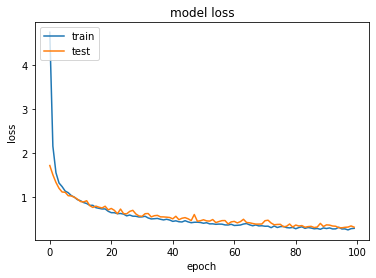

In [ ]:
plt.plot(CNN_MODEL.history['loss'])
plt.plot(CNN_MODEL.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()


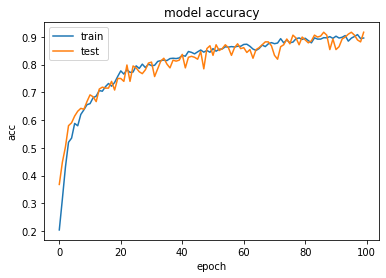

In [ ]:
plt.plot(CNN_MODEL.history['accuracy'])
plt.plot(CNN_MODEL.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')



plt.show()

## **Plotting  the Confusion matrix of the model**.
* `Confusion Matrix`-- A confusion matrix is a quick way to compare the labels a model predicts and the actual labels it as supposed to predict.
It gives us an idea where model is getting confused.

36/36 [==============================] - 0s 2ms/step


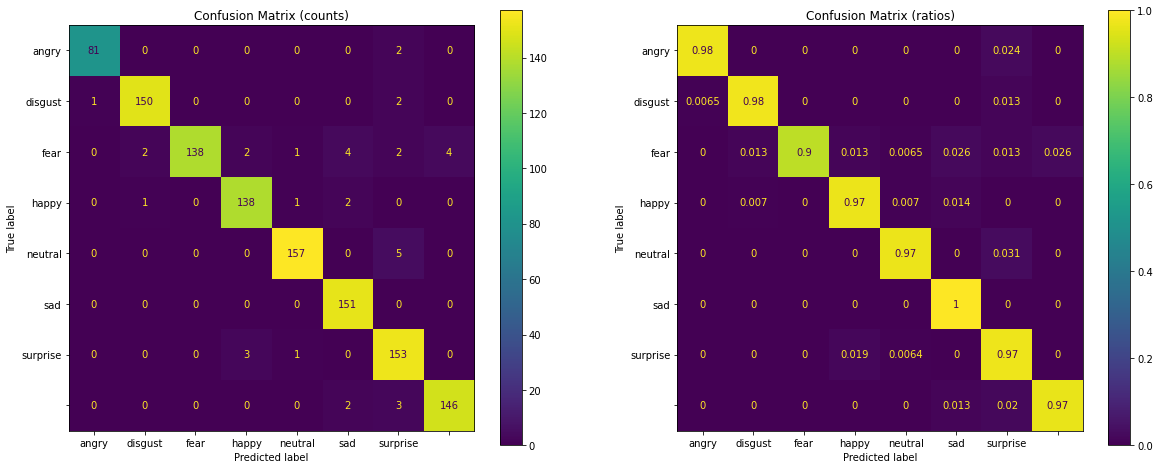

In [ ]:
#Predictions
predictions = model.predict(x_test1)

pred = []

for i in predictions:
    pred.append(np.argmax(i))

from sklearn.metrics import ConfusionMatrixDisplay

labels = {'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}

def plot_confusion_matrices(y_true, y_pred):
    '''
    This Function take True and predicted value of the test data and
    plot a confusion matrix.
    '''

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plots the standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, ax=ax1)

    # Plots the normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, normalize="true", ax=ax2)

    plt.show()

# Plot confusion matrices
plot_confusion_matrices(y_test1, pred)

## Predicting the result from the model on a test set.
* Calculating the accuracy of the model on the test set of data.


In [ ]:
# Collect loss and accuracy for the test set
loss_te, accuracy_te = model.evaluate(x_test1, y_test1)

print("Test loss: {:.2f}".format(loss_te))
print("Test accuracy: {:.2f}%".format(100 * accuracy_te))

36/36 [==============================] - 0s 2ms/step - loss: 0.1531 - accuracy: 0.9670
Test loss: 0.15
Test accuracy: 96.70%
